In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from spatial_transformer import *
from utils.get_data import CUBDataLoader
from scipy.misc import imresize



%load_ext autoreload
%matplotlib inline

In [3]:
# code to reshape theta
theta = tf.placeholder(tf.float32, shape=(None, 4))
batch_size = tf.shape(theta)[0]
print('batch size:', batch_size)
# theta1 = [t_x1, t_y1], theta2 = [t_x2, t_y2]
theta1, theta2 = tf.split(theta, num_or_size_splits=2, axis=1)
theta1, theta2 = tf.reshape(theta1, [-1, 2, 1]), tf.reshape(theta2, [-1, 2, 1])
theta_scale = tf.eye(2, batch_shape=[batch_size]) * 0.5
print('theta scale shape:', theta_scale.get_shape())
# theta1 = [0.5 0  t_x1]
#          [0  0.5 t_y1]
# theta2 = [0.5 0  t_x2]
#          [0  0.5 t_y2]
theta1 = tf.concat([theta_scale, theta1], axis=2)
theta2 = tf.concat([theta_scale, theta2], axis=2)
theta1, theta2 = tf.reshape(theta1, [batch_size, 6]), tf.reshape(theta2, [batch_size, 6])

('batch size:', <tf.Tensor 'strided_slice:0' shape=() dtype=int32>)
('theta scale shape:', TensorShape([Dimension(None), Dimension(2), Dimension(2)]))


In [4]:
feed_dict = {theta : np.array([[100.0, 90.0, 1.0, 2.0]])}
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
theta1_value, theta2_value = sess.run([theta1, theta2], feed_dict=feed_dict)
print(theta1_value)
print('theta1_value:', theta1_value.reshape(1, 2, 3), 'theta2_value', theta2_value.reshape(1, 2, 3))

[[   0.5    0.   100.     0.     0.5   90. ]]
('theta1_value:', array([[[   0.5,    0. ,  100. ],
        [   0. ,    0.5,   90. ]]], dtype=float32), 'theta2_value', array([[[ 0.5,  0. ,  1. ],
        [ 0. ,  0.5,  2. ]]], dtype=float32))


In [5]:
# code to test using stn
images = tf.placeholder(tf.float32, shape=[1, 244, 244, 3])
is_training = tf.placeholder(tf.bool)
theta = tf.placeholder(tf.float32, shape=[1, 6])
trans = transform(images, theta, out_size=(244, 244))

Transform input: (1, 244, 244, 3)
('tf.shape(imput_dim):', TensorShape([Dimension(1), Dimension(244), Dimension(244), Dimension(3)]))
('output shape:', TensorShape([Dimension(None), Dimension(244), Dimension(244), Dimension(3)]))
('num channels:', Dimension(3))


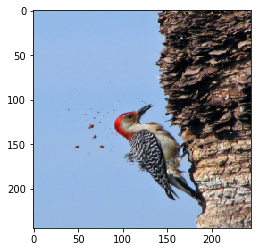

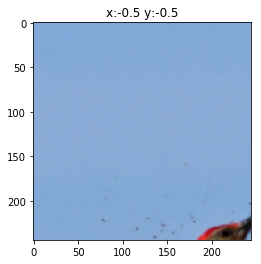

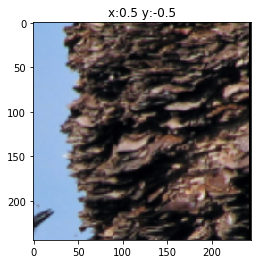

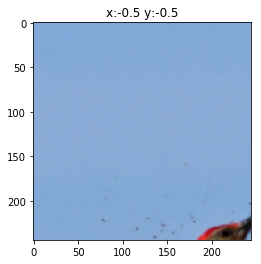

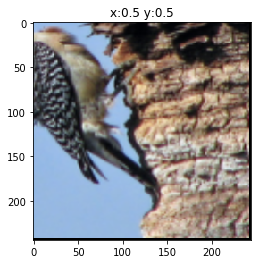

In [24]:
CURRENT_DIR = '/home/jason/birds-stn/src'
PATH = '/home/jason/datasets/CUB_200_2011/images/189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0012_181765.jpg'

#cub = CUBDataLoader()
#train_test_files = [os.path.join(CURRENT_DIR, 'utils/train.txt'), os.path.join(CURRENT_DIR, 'utils/test.txt')]
#(train_x, train_y), (test_x, test_y) = cub.get_data(train_test_files)
#print(train_x[0])

img = mpimg.imread(PATH)
img = imresize(img, (244, 244, 3)) / 255.0
imgplot = plt.imshow(img)



config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init_op = tf.global_variables_initializer()
sess.run(init_op)

values = [(-0.5, -0.5), (0.5, -0.5), (-0.5, -0.5), (0.5, 0.5)]
for x, y in values:
        params = np.array([[0.5, 0, x], [0, 0.5, y]])
        params = params.astype('float32')
        params = np.expand_dims(params.flatten(), 0)
        trans_value = sess.run(trans, feed_dict={images : np.expand_dims(img, 0), is_training : True, theta : params})
        plt.figure()
        plt.title('x:'+str(x)+' y:'+str(y))
        imgplot = plt.imshow(trans_value[0] + -np.min(trans_value))

In [6]:
from scipy import ndimage
import tensorflow as tf
from spatial_transformer import transform
import numpy as np
import matplotlib.pyplot as plt

# %% Create a batch of three images (1600 x 1200)
# %% Image retrieved from:
# %% https://raw.githubusercontent.com/skaae/transformer_network/master/cat.jpg
im = ndimage.imread('cat.jpg')
im = im / 255.
im = im.reshape(1, 1200, 1600, 3)
im = im.astype('float32')

# %% Let the output size of the transformer be half the image size.
out_size = (600, 800)

# %% Simulate batch
batch = np.append(im, im, axis=0)
batch = np.append(batch, im, axis=0)
num_batch = 3

x = tf.placeholder(tf.float32, [None, 1200, 1600, 3])
x = tf.cast(batch, 'float32')

# %% Create localisation network and convolutional layer
with tf.variable_scope('spatial_transformer_0'):

    # %% Create a fully-connected layer with 6 output nodes
    n_fc = 6
    W_fc1 = tf.Variable(tf.zeros([1200 * 1600 * 3, n_fc]), name='W_fc1')

    # %% Zoom into the image
    initial = np.array([[0.5, 0, 0], [0, 0.5, 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    print(initial)

    b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')
    h_fc1 = tf.matmul(tf.zeros([num_batch, 1200 * 1600 * 3]), W_fc1) + b_fc1
    h_trans = transform(x, h_fc1, out_size)

# %% Run session
sess = tf.Session()
sess.run(tf.initialize_all_variables())
[y, params] = sess.run([h_trans, h_fc1], feed_dict={x: batch})

print('params:', params)

plt.imshow(y[0])

[ 0.5  0.   0.   0.   0.5  0. ]
Transform input: (3, 1200, 1600, 3)
('tf.shape(imput_dim):', TensorShape([Dimension(3), Dimension(1200), Dimension(1600), Dimension(3)]))
('output shape:', TensorShape([Dimension(None), Dimension(600), Dimension(800), Dimension(3)]))
('num channels:', Dimension(3))
Instructions for updating:
Use `tf.global_variables_initializer` instead.


ResourceExhaustedError: OOM when allocating tensor of shape [5760000,6] and type float
	 [[Node: spatial_transformer_0/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5760000,6] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'spatial_transformer_0/zeros', defined at:
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-59f045ed9d62>", line 31, in <module>
    W_fc1 = tf.Variable(tf.zeros([1200 * 1600 * 3, n_fc]), name='W_fc1')
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1439, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/constant_op.py", line 214, in constant
    name=name).outputs[0]
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/jason/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [5760000,6] and type float
	 [[Node: spatial_transformer_0/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5760000,6] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
